In [2]:
# thinking about how the probability mass should be distributed
# why is the ideal model just the normalized counts

In [3]:
import numpy as np
import torch

In [4]:
xs = np.arange(0, 1.0, 0.01)
xs_complement = 1 - xs

# area perimeter tradeoff is far more general than just geometry
xs ** 3 * xs_complement

array([0.0000000e+00, 9.9000000e-07, 7.8400000e-06, 2.6190000e-05,
       6.1440000e-05, 1.1875000e-04, 2.0304000e-04, 3.1899000e-04,
       4.7104000e-04, 6.6339000e-04, 9.0000000e-04, 1.1845900e-03,
       1.5206400e-03, 1.9113900e-03, 2.3598400e-03, 2.8687500e-03,
       3.4406400e-03, 4.0777900e-03, 4.7822400e-03, 5.5557900e-03,
       6.4000000e-03, 7.3161900e-03, 8.3054400e-03, 9.3685900e-03,
       1.0506240e-02, 1.1718750e-02, 1.3006240e-02, 1.4368590e-02,
       1.5805440e-02, 1.7316190e-02, 1.8900000e-02, 2.0555790e-02,
       2.2282240e-02, 2.4077790e-02, 2.5940640e-02, 2.7868750e-02,
       2.9859840e-02, 3.1911390e-02, 3.4020640e-02, 3.6184590e-02,
       3.8400000e-02, 4.0663390e-02, 4.2971040e-02, 4.5318990e-02,
       4.7703040e-02, 5.0118750e-02, 5.2561440e-02, 5.5026190e-02,
       5.7507840e-02, 6.0000990e-02, 6.2500000e-02, 6.4998990e-02,
       6.7491840e-02, 6.9972190e-02, 7.2433440e-02, 7.4868750e-02,
       7.7271040e-02, 7.9632990e-02, 8.1947040e-02, 8.4205390e

In [5]:
raw = open("./data/names.txt").read()
names = raw.split("\n")

len(names), len(set("".join(names)))

(32033, 26)

In [6]:
bigrams_dict = {}
for name in names:
  name = "." + name + "."
  for idx in range(1, len(name)):
    bigram = (name[idx - 1], name[idx])
    bigrams_dict[bigram] = bigrams_dict.get(bigram, 0) + 1

In [7]:
characters = set("".join(names))
characters.add(".")
char_to_idx = {char: idx for idx, char in enumerate(sorted(list(characters)))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [8]:
W = torch.zeros((len(characters), len(characters)))
for name in names:
  name = "." + name + "."
  for idx in range(1, len(name)):
    char1 = name[idx - 1]; char2 = name[idx]
    W[char_to_idx[char1], char_to_idx[char2]] += 1

In [9]:
W_normalized = W / W.sum(dim=1, keepdim=True)

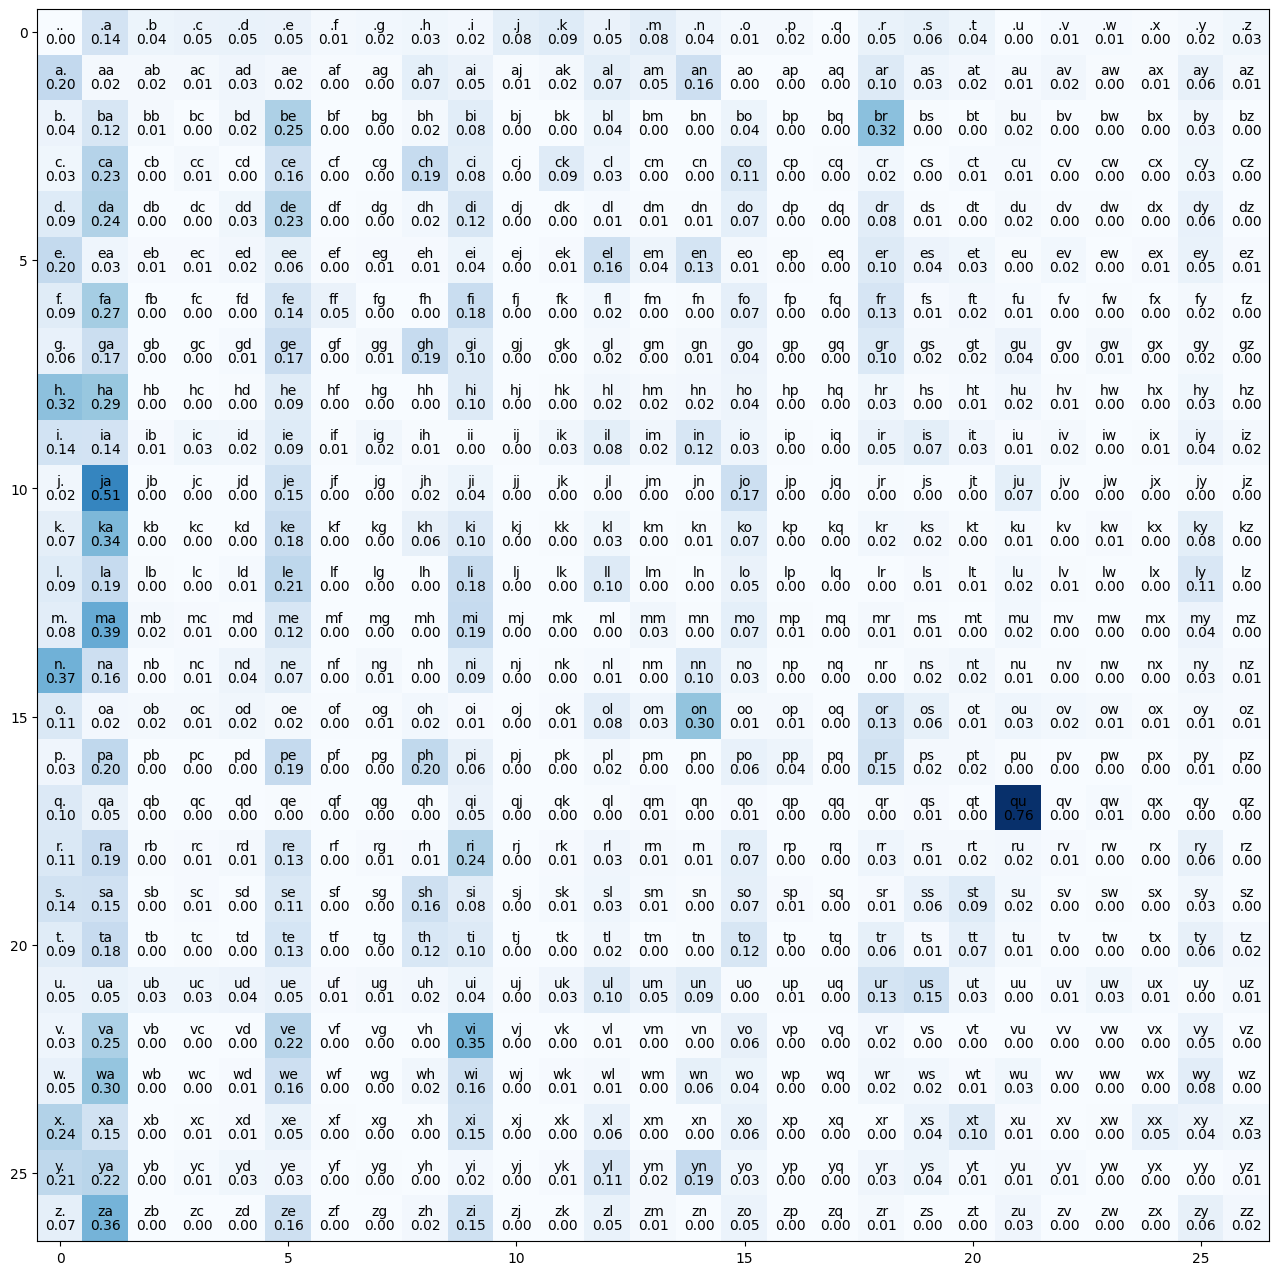

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
plt.imshow(W_normalized, cmap="Blues")
for i in range(W.shape[0]):
  for j in range(W.shape[1]):
    plt.text(j, i, idx_to_char[i] + idx_to_char[j], ha="center", va="bottom", color="black")
    plt.text(j, i, f"{W_normalized[i, j]:.2f}", ha="center", va="top", color="black")
    # plt.text(j, i, f"", ha="center", va="bottom", color="black")

In [11]:
# sampling
samples = []
generator = torch.Generator().manual_seed(14)
for _ in range(10):
  sample = "."
  while sample[-1] != "." or len(sample) == 1:
    last_char_idx = char_to_idx[sample[-1]]
    # sampled_idx = torch.multinomial(torch.ones(len(characters)) / len(characters), 1, generator=generator).item() # uniform distribution sanity check
    sampled_idx = torch.multinomial(W_normalized[last_char_idx], 1, generator=generator).item()
    sample += idx_to_char[sampled_idx]
  samples.append(sample)
  print(sample)

.annipryesosah.
.ftorbemylimah.
.ichiawy.
.a.
.s.
.eoneyn.
.besen.
.gaylish.
.brylya.
.wemcha.


In [12]:
# best possible loss of the nn model
# nn model will converge to bigram counts

total_nll = 0
total_examples = 0
for name in names:
  name = "." + name + "."
  for idx in range(1, len(name)):
    char1 = name[idx - 1]; char2 = name[idx]
    prob = W_normalized[char_to_idx[char1], char_to_idx[char2]]
    example_nll = -torch.log(prob)
    total_nll += example_nll; total_examples += 1

total_nll / total_examples

tensor(2.4541)

In [ ]:
# things to keep in mind: 
# - what does it mean to have negative fractional exponents?
# - area perimeter tradeoff generalization

In [20]:
# NN model. 
# have one large weight matrix that is tuned over backprop to match the normalized bigram counts
generator = torch.Generator().manual_seed(14)
w = torch.randn((len(characters), len(characters)), requires_grad=True, generator=generator)

In [33]:
dataset = []
for name in names:
  name = "." + name + "."
  for idx in range(1, len(name)):
    char1 = name[idx - 1]; char2 = name[idx]
    char1_idx = char_to_idx[char1]; char2_idx = char_to_idx[char2]
    dataset.append([char1_idx, char2_idx])

dataset = torch.tensor(dataset)
generator = torch.Generator().manual_seed(14)
dataset_shuffled = dataset[torch.randperm(len(dataset), generator=generator)]
X = dataset_shuffled[:, 0]; Y = dataset_shuffled[:, 1]
identity = torch.eye(len(characters))
X_ohe = identity[X]

train_idx_cutoff = int(0.8 * len(X))
X_train = X_ohe[:train_idx_cutoff]; Y_train = Y[:train_idx_cutoff]
X_leftover = X_ohe[train_idx_cutoff:]; Y_leftover = Y[train_idx_cutoff:]

val_test_idx_cutoff = int(0.5 * len(X_leftover))
X_val = X_leftover[:val_test_idx_cutoff]; Y_val = Y_leftover[:val_test_idx_cutoff]
X_test = X_leftover[val_test_idx_cutoff:]; Y_test = Y_leftover[val_test_idx_cutoff:]

X_train.shape, X_val.shape, X_test.shape

(torch.Size([182516, 27]), torch.Size([22815, 27]), torch.Size([22815, 27]))

In [45]:
cmp_1 = W_normalized[0]
cmp_2 = torch.eye(27)[0] @ W_normalized
torch.all(cmp_1 == cmp_2)

tensor(True)

In [58]:
# forward pass
selections = X_train @ w
logits = torch.exp(selections)
probs = logits / logits.sum(dim=1, keepdim=True)
probs_of_interest = probs[torch.arange(probs.shape[0]), Y_train]
nll_of_interest = -torch.log(probs_of_interest)
loss = nll_of_interest.mean()
loss

tensor(3.9186, grad_fn=<MeanBackward0>)

tensor(0.0962)

In [74]:
# training loop
for _ in range(100):

  if w.grad is not None:
    w.grad.zero_()

  selections = X_train @ w
  logits = torch.exp(selections)
  probs = logits / logits.sum(dim=1, keepdim=True)
  probs_of_interest = probs[torch.arange(probs.shape[0]), Y_train]
  nll_of_interest = -torch.log(probs_of_interest)
  loss = nll_of_interest.mean()

  print(loss)

  loss.backward()
  learning_rate = 0.1
  w.data -= learning_rate * w.grad

w.grad.norm()

tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5195, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)
tensor(2.5194, grad_fn=<MeanBackward0>)


tensor(0.0066)

In [76]:
# validation loss check
with torch.no_grad():
  selections = X_val @ w
  logits = torch.exp(selections)
  probs = logits / logits.sum(dim=1, keepdim=True)
  probs_of_interest = probs[torch.arange(probs.shape[0]), Y_val]
  nll_of_interest = -torch.log(probs_of_interest)
  loss = nll_of_interest.mean()
  print(loss)

tensor(2.5196)


In [82]:
w_probs = None
with torch.no_grad():
  logits = torch.exp(w)
  probs = logits / logits.sum(dim=1, keepdim=True)
  w_probs = probs

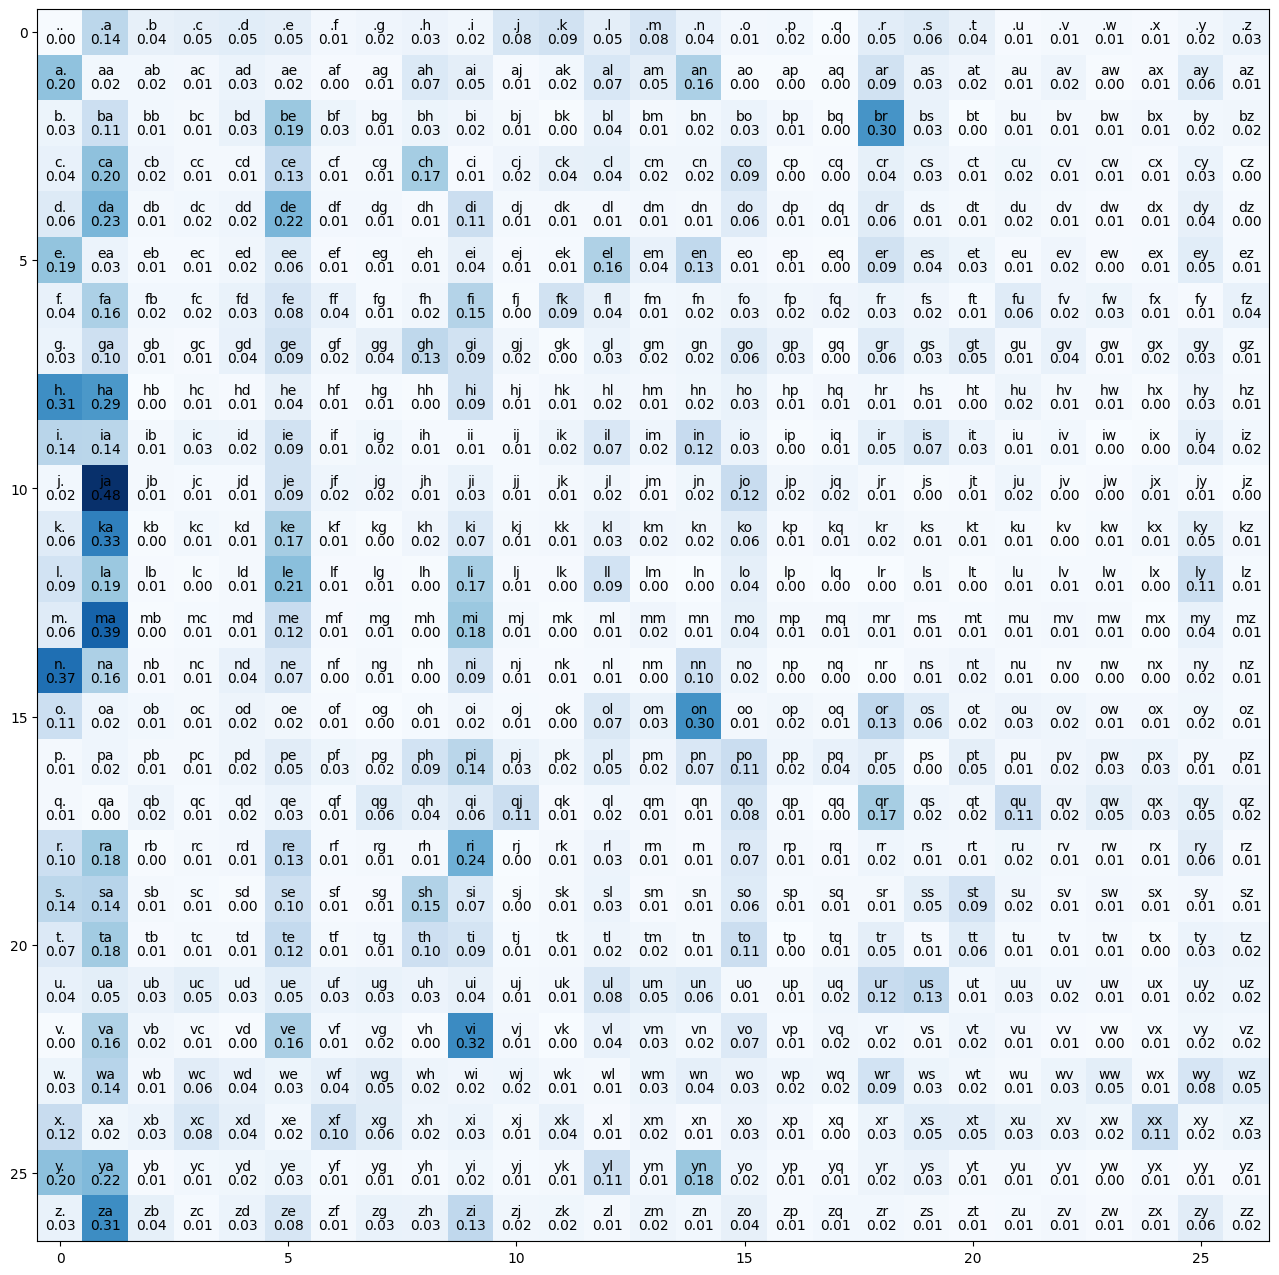

In [85]:
plt.figure(figsize=(16, 16))
plt.imshow(w_probs, cmap="Blues")

for i in range(w_probs.shape[0]):
  for j in range(w_probs.shape[1]):
    plt.text(j, i, idx_to_char[i] + idx_to_char[j], ha="center", va="bottom", color="black")
    plt.text(j, i, f"{w_probs[i, j]:.2f}", ha="center", va="top", color="black")

In [ ]:
# there is a difference, but could just be due to train split being odd. 
# going to verify with the entire dataset

In [88]:
# training loop

generator = torch.Generator().manual_seed(14)
w_alt = torch.randn((len(characters), len(characters)), requires_grad=True, generator=generator)

losses = []
for iter in range(1000):

  if w_alt.grad is not None:
    w_alt.grad.zero_()

  selections = X_ohe @ w_alt
  logits = torch.exp(selections)
  probs = logits / logits.sum(dim=1, keepdim=True)
  probs_of_interest = probs[torch.arange(probs.shape[0]), Y]
  nll_of_interest = -torch.log(probs_of_interest)
  loss = nll_of_interest.mean()
  losses.append(loss.item())
  loss.backward()

  if iter < 250:
    learning_rate = 5
  elif iter < 500:
    learning_rate = 1
  elif iter < 750:
    learning_rate = 0.5

  w_alt.data -= learning_rate * w_alt.grad

  if iter % 100 == 0:
    print(loss, w_alt.norm())


tensor(3.9185, grad_fn=<MeanBackward0>) tensor(27.2420, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.6833, grad_fn=<MeanBackward0>) tensor(25.8236, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5736, grad_fn=<MeanBackward0>) tensor(27.5295, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5441, grad_fn=<MeanBackward0>) tensor(28.4563, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5370, grad_fn=<MeanBackward0>) tensor(28.7530, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5307, grad_fn=<MeanBackward0>) tensor(29.0402, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5279, grad_fn=<MeanBackward0>) tensor(29.1813, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5253, grad_fn=<MeanBackward0>) tensor(29.3204, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5228, grad_fn=<MeanBackward0>) tensor(29.4574, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5205, grad_fn=<MeanBackward0>) tensor(29.5923, grad_fn=<LinalgVectorNormBackward0>)


In [89]:
w_alt_probs = None
with torch.no_grad():
  logits = torch.exp(w_alt)
  probs = logits / logits.sum(dim=1, keepdim=True)
  w_alt_probs = probs

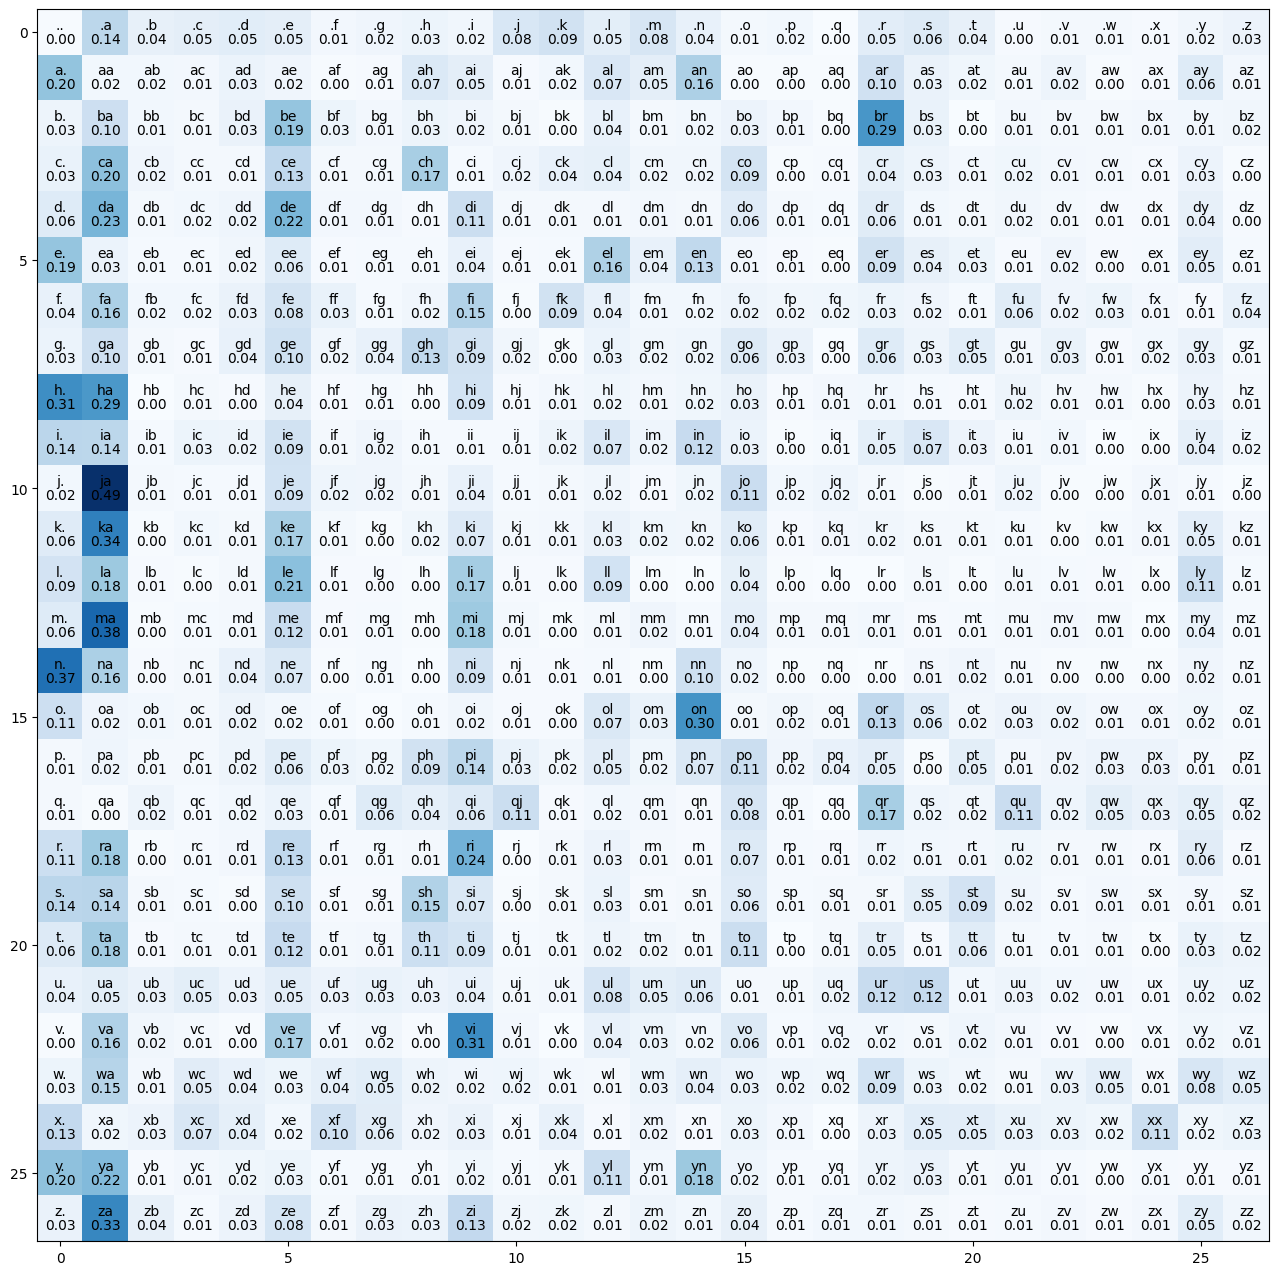

In [90]:
plt.figure(figsize=(16, 16))
plt.imshow(w_alt_probs, cmap="Blues")

for i in range(w_alt_probs.shape[0]):
  for j in range(w_alt_probs.shape[1]):
    plt.text(j, i, idx_to_char[i] + idx_to_char[j], ha="center", va="bottom", color="black")
    plt.text(j, i, f"{w_alt_probs[i, j]:.2f}", ha="center", va="top", color="black")

In [ ]:
# interesting. if i had to guess probably something to do with local minima. the sets with a lot of characters are approximately right, but the bigrams that are uncommon, are not as correct. they have lesser impact on mean_nll, so updates can be whatever to a large extent.